# Predição de Lutas do UFC com Machine Learning

Neste notebook utilizo o dataset **UFC Datasets 1994–2025** (Kaggle) para resolver três tarefas de aprendizado supervisionado:

1. Prever **quem vence a luta** (corner vermelho ou azul);
2. Prever o **método de vitória** (decisão, KO/TKO, finalização, etc.);
3. Estimar a **duração da luta**, em segundos.

O foco é aplicar técnicas de EDA, engenharia de atributos, validação cruzada e comparação entre modelos de classificação e regressão.


## Carregando o dataset do UFC

Baixei o dataset diretamente do Kaggle usando `kagglehub` e carreguei o arquivo principal `UFC.csv`, que já consolida informações do evento, dos lutadores e das estatísticas da luta.


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("neelagiriaditya/ufc-datasets-1994-2025")

print("Path to dataset files:", path)

C:\Users\igorr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\igorr\.cache\kagglehub\datasets\neelagiriaditya\ufc-datasets-1994-2025\versions\3


In [2]:
import os
import pandas as pd

# listar arquivos baixados
files = os.listdir(path)
files


['event_details.csv', 'fighter_details.csv', 'fight_details.csv', 'UFC.csv']

## 2. Leitura do arquivo principal `UFC.csv`

O arquivo `UFC.csv` é o dataset consolidado com uma linha por luta, contendo:

- informações do evento (nome, data, local, categoria de peso);
- estatísticas do lutador do corner vermelho (`r_*`);
- estatísticas do lutador do corner azul (`b_*`);
- informações do resultado (`winner`, `method`, `finish_round`, `match_time_sec`, etc.).


In [3]:
import os
import pandas as pd

ufc_path = os.path.join(path, "UFC.csv")
df = pd.read_csv(ufc_path)

print("Shape:", df.shape)
df.head(3)


Shape: (8337, 124)


,event_id,event_name,date,location,fight_id,division,title_fight,method,finish_round,match_time_sec,...,b_splm,b_str_acc,b_sapm,b_str_def,b_td_avg,b_td_avg_acc,b_td_def,b_sub_avg,winner,winner_id
0,6e380a4d73ab4f0e,UFC Fight Night: Imavov vs. Borralho,2025/09/06,"Paris, Ile-de-France, France",d14fea43712707f0,lightweight,0,Submission,2,176,...,3.84,57,4.16,60,0.00,0,84,0.0,Benoit Saint Denis,c2299ec916bc7c56
1,6e380a4d73ab4f0e,UFC Fight Night: Imavov vs. Borralho,2025/09/06,"Paris, Ile-de-France, France",5bcd8abf6da01dae,middleweight,0,Decision - Unanimous,5,300,...,3.44,56,2.50,60,1.28,48,76,0.4,Nassourdine Imavov,881bf86d4cba8578
2,6e380a4d73ab4f0e,UFC Fight Night: Imavov vs. Borralho,2025/09/06,"Paris, Ile-de-France, France",0149e875b31e57f8,light heavyweight,0,KO/TKO,1,300,...,2.50,45,3.04,43,1.43,18,35,1.3,Modestas Bukauskas,476fe566d2df676e


In [ ]:
#df.columns.tolist()


['event_id',
 'event_name',
 'date',
 'location',
 'fight_id',
 'division',
 'title_fight',
 'method',
 'finish_round',
 'match_time_sec',
 'total_rounds',
 'referee',
 'r_name',
 'r_id',
 'r_kd',
 'r_sig_str_landed',
 'r_sig_str_atmpted',
 'r_sig_str_acc',
 'r_total_str_landed',
 'r_total_str_atmpted',
 'r_total_str_acc',
 'r_td_landed',
 'r_td_atmpted',
 'r_td_acc',
 'r_sub_att',
 'r_ctrl',
 'r_head_landed',
 'r_head_atmpted',
 'r_head_acc',
 'r_body_landed',
 'r_body_atmpted',
 'r_body_acc',
 'r_leg_landed',
 'r_leg_atmpted',
 'r_leg_acc',
 'r_dist_landed',
 'r_dist_atmpted',
 'r_dist_acc',
 'r_clinch_landed',
 'r_clinch_atmpted',
 'r_clinch_acc',
 'r_ground_landed',
 'r_ground_atmpted',
 'r_ground_acc',
 'r_landed_head_per',
 'r_landed_body_per',
 'r_landed_leg_per',
 'r_landed_dist_per',
 'r_landed_clinch_per',
 'r_landed_ground_per',
 'r_nick_name',
 'r_wins',
 'r_losses',
 'r_draws',
 'r_height',
 'r_weight',
 'r_reach',
 'r_stance',
 'r_dob',
 'r_splm',
 'r_str_acc',
 'r_sapm',

In [ ]:
#df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8337 entries, 0 to 8336
Columns: 124 entries, event_id to winner_id
dtypes: float64(87), int64(17), object(20)
memory usage: 7.9+ MB


## 3. Criação das variáveis alvo (targets)

Definidos três problemas supervisionados a partir do dataset:

1. **Problema 1 – Classificação binária (vencedor)**  
   `winner_bin`: vale 1 se o vencedor é o lutador do corner vermelho (`r_name`) e 0 se o vencedor é o lutador do corner azul.

2. **Problema 2 – Classificação multiclasse (método de vitória)**  
   `method_simplified`: agrupamos o método de vitória original em quatro grupos principais:  
   `Decision`, `KO/TKO`, `Submission` e `Other`.

3. **Problema 3 – Regressão (duração da luta)**  
   `duration` / `duration_sec`: utilizamos o tempo total de luta, em segundos, como variável alvo da regressão.


In [21]:
# Problema 1: vencedor (1 = Red wins, 0 = Blue wins)

df['winner_bin'] = (df['winner'] == df['r_name']).astype(int)



# Problema 2: método de vitória simplificado
def simplify_method(x):
    if isinstance(x, str):
        x_lower = x.lower()
        if "ko" in x_lower:
            return "KO/TKO"
        elif "sub" in x_lower:
            return "Submission"
        elif "dec" in x_lower:
            return "Decision"
    return "Other"   # fallback

df['method_simplified'] = df['method'].apply(simplify_method)


# Problema 3: duração (vamos usar match_time_sec mais à frente)
df['duration'] = df['total_rounds']
df['duration_sec'] = df['match_time_sec'] 


## 4. Engenharia de atributos: diferenças entre lutadores

Nesta etapa foram criadas variáveis que representam a **vantagem relativa** do lutador do corner vermelho em relação ao azul.  

Exemplos:

- `kd_diff`: diferença no número de knockdowns;
- `sig_str_diff`: diferença de golpes significativos conectados;
- `td_diff`: diferença no número de quedas (takedowns);
- `height_diff`, `weight_diff`, `reach_diff`: diferenças físicas de altura, peso e envergadura.

Essas features ajudam o modelo a capturar quem está em vantagem em cada aspecto técnico e físico.


In [22]:
import numpy as np

# Criação de features de diferença Red - Blue

def create_diff(df, r_col, b_col, new_name):
    if r_col in df.columns and b_col in df.columns:
        df[new_name] = df[r_col] - df[b_col]
    else:
        print(f"⚠ Columns not found: {r_col}, {b_col}")


diff_pairs = [
    ("r_kd", "b_kd", "kd_diff"),
    ("r_sig_str_landed", "b_sig_str_landed", "sig_str_diff"),
    ("r_sig_str_atmpted", "b_sig_str_atmpted", "sig_str_att_diff"),
    ("r_sig_str_acc", "b_sig_str_acc", "sig_str_acc_diff"),
    ("r_total_str_landed", "b_total_str_landed", "total_str_diff"),
    ("r_total_str_acc", "b_total_str_acc", "total_str_acc_diff"),
    ("r_td_landed", "b_td_landed", "td_diff"),
    ("r_td_acc", "b_td_acc", "td_acc_diff"),
    ("r_sub_att", "b_sub_att", "sub_att_diff"),
    ("r_rev", "b_rev", "rev_diff"),
    ("r_ctrl_time", "b_ctrl_time", "ctrl_time_diff"),

    # Atributos físicos
    ("r_height", "b_height", "height_diff"),
    ("r_weight", "b_weight", "weight_diff"),
    ("r_reach", "b_reach", "reach_diff"),
    ("r_age", "b_age", "age_diff"),
]


for r, b, new_col in diff_pairs:
    create_diff(df, r, b, new_col)

print("Feature engineering concluída. Novas colunas adicionadas:")
[x for x in df.columns if x.endswith("_diff")]


⚠ Columns not found: r_rev, b_rev
⚠ Columns not found: r_ctrl_time, b_ctrl_time
⚠ Columns not found: r_age, b_age
Feature engineering concluída. Novas colunas adicionadas:


['kd_diff',
 'sig_str_diff',
 'sig_str_att_diff',
 'sig_str_acc_diff',
 'total_str_diff',
 'total_str_acc_diff',
 'td_diff',
 'td_acc_diff',
 'sub_att_diff',
 'height_diff',
 'weight_diff',
 'reach_diff']

## 5. Split temporal em treino e teste

Para evitar *data leakage*, separei o dataset em treino e teste com base na data da luta:

- **Treino:** lutas anteriores a 01/01/2022;
- **Teste:** lutas a partir de 01/01/2022.

Dessa forma podemos treinar o modelo com lutas antigas e avaliamos em lutas mais recentes, simulando um cenário realista.


In [23]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Remover lutas sem data válida
df = df.dropna(subset=['date'])

# Ordenar pela data
df = df.sort_values('date')

# Split temporal:
train_df = df[df['date'] < "2022-01-01"]
test_df  = df[df['date'] >= "2022-01-01"]

print("Train:", train_df.shape)
print("Test :", test_df.shape)


Train: (6426, 140)
Test : (1911, 140)


## 6. Problema 1 – Previsão do vencedor (classificação binária)

Nesta seção quero prever **qual corner vence a luta** (vermelho ou azul).  

Removo do conjunto de features:

- IDs e nomes (event_id, event_name, r_name, b_name, etc.);
- colunas que revelam o resultado (`winner`, `winner_id`, `method`, `finish_round`, `match_time_sec`, `total_rounds`, `duration`);
- o próprio alvo (`winner_bin`).

As demais colunas numéricas e categóricas (incluindo as diferenças Red–Blue) são usadas como preditoras.


In [24]:
# colunas que não usarei como features (ids, nomes, resultado, datas, etc.)
base_exclude = [
    'event_id', 'event_name', 'date', 'location', 'fight_id',
    'r_name', 'r_id', 'b_name', 'b_id', 'referee',
    'winner', 'winner_id',
    'method',         
    'finish_round',    
    'match_time_sec', 
    'total_rounds',    
    'duration',      
]


exclude_A = base_exclude + ['winner_bin', 'method_simplified']

# todas as colunas menos as excluídas
feature_cols_A = [c for c in train_df.columns if c not in exclude_A]

print("Número de features para Problema 1:", len(feature_cols_A))
print("Algumas delas:", feature_cols_A[:25])


cat_cols = [c for c in ['division', 'title_fight'] if c in feature_cols_A]


num_cols_A = [c for c in feature_cols_A if c not in cat_cols]

print("\nCategóricas usadas:", cat_cols)
print("Nº de features numéricas:", len(num_cols_A))


Número de features para Problema 1: 121
Algumas delas: ['division', 'title_fight', 'r_kd', 'r_sig_str_landed', 'r_sig_str_atmpted', 'r_sig_str_acc', 'r_total_str_landed', 'r_total_str_atmpted', 'r_total_str_acc', 'r_td_landed', 'r_td_atmpted', 'r_td_acc', 'r_sub_att', 'r_ctrl', 'r_head_landed', 'r_head_atmpted', 'r_head_acc', 'r_body_landed', 'r_body_atmpted', 'r_body_acc', 'r_leg_landed', 'r_leg_atmpted', 'r_leg_acc', 'r_dist_landed', 'r_dist_atmpted']

Categóricas usadas: ['division', 'title_fight']
Nº de features numéricas: 119


### 6.1 Modelo 1 – Regressão Logística

Montado um pipeline com:

- imputação e padronização para variáveis numéricas;
- imputação e *one-hot encoding* para variáveis categóricas;
- **Regressão Logística** como classificador.

Avaliando o modelo no conjunto de teste usando accuracy, relatório de classificação e AUC-ROC.


X_train_A: (6307, 121)
X_test_A : (1883, 121)

Categóricas detectadas: ['division', 'r_nick_name', 'r_stance', 'r_dob', 'b_nick_name', 'b_stance', 'b_dob']
Nº de features numéricas: 114

--- Métricas Problema 1: Vencedor (Logistic Regression) ---
              precision    recall  f1-score   support

           0      0.871     0.851     0.861       812
           1      0.889     0.905     0.897      1071

    accuracy                          0.882      1883
   macro avg      0.880     0.878     0.879      1883
weighted avg      0.881     0.882     0.881      1883

AUC-ROC: 0.948


<Figure size 400x400 with 0 Axes>

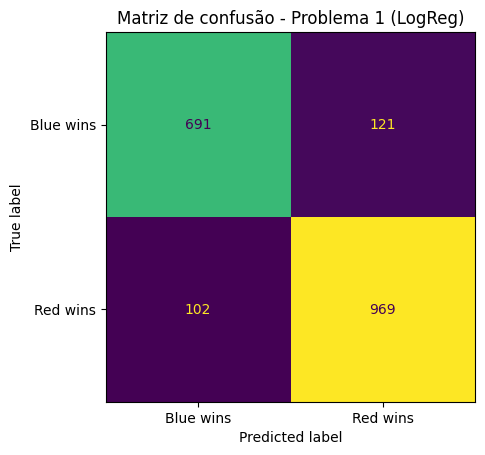

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

# 1) Garantindo que não estou pegando lutas sem vencedor definido
trainA_df = train_df.dropna(subset=['winner'])
testA_df  = test_df.dropna(subset=['winner'])

X_train_A = trainA_df[feature_cols_A]
y_train_A = trainA_df['winner_bin']

X_test_A  = testA_df[feature_cols_A]
y_test_A  = testA_df['winner_bin']

print("X_train_A:", X_train_A.shape)
print("X_test_A :", X_test_A.shape)

# 2) Definir colunas numéricas e categóricas com base no dtype REAL
cat_cols = X_train_A.select_dtypes(include=['object', 'bool']).columns.tolist()
num_cols_A = X_train_A.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nCategóricas detectadas:", cat_cols)
print("Nº de features numéricas:", len(num_cols_A))


# 3) Transformers para numéricas e categóricas
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_A = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols_A),
        ("cat", categorical_transformer, cat_cols),
    ]
)

# 4) Pipeline final com Regressão Logística
logreg_clf = Pipeline(steps=[
    ("prep", preprocess_A),
    ("model", LogisticRegression(max_iter=1000))
])

# 5) Treinar
logreg_clf.fit(X_train_A, y_train_A)

# 6) Avaliar no conjunto de teste
y_pred_A = logreg_clf.predict(X_test_A)
y_proba_A = logreg_clf.predict_proba(X_test_A)[:, 1]

print("\n--- Métricas Problema 1: Vencedor (Logistic Regression) ---")
print(classification_report(y_test_A, y_pred_A, digits=3))

auc = roc_auc_score(y_test_A, y_proba_A)
print(f"AUC-ROC: {auc:.3f}")

# Matriz de confusão
cm = confusion_matrix(y_test_A, y_pred_A)

plt.figure(figsize=(4,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Blue wins","Red wins"])
disp.plot(colorbar=False)
plt.title("Matriz de confusão - Problema 1 (LogReg)")
plt.show()


### 6.2 Modelo 2 – Random Forest

Como segundo modelo para o problema de vencedor, utilizamos um **Random Forest Classifier** com validação cruzada estratificada (5-fold) e AUC-ROC como métrica principal.

Comparamos o desempenho do Random Forest com o da Regressão Logística para escolher o melhor modelo para este problema.


AUC-ROC (CV 5-fold) - Random Forest: [0.94537858 0.93010046 0.94965734 0.94197296 0.94673929]
Média AUC-ROC (CV): 0.943 ± 0.007

--- Métricas Problema 1: Vencedor (Random Forest) ---
              precision    recall  f1-score   support

           0      0.919     0.757     0.831       812
           1      0.838     0.950     0.890      1071

    accuracy                          0.867      1883
   macro avg      0.879     0.853     0.860      1883
weighted avg      0.873     0.867     0.864      1883

AUC-ROC (Random Forest): 0.946


<Figure size 400x400 with 0 Axes>

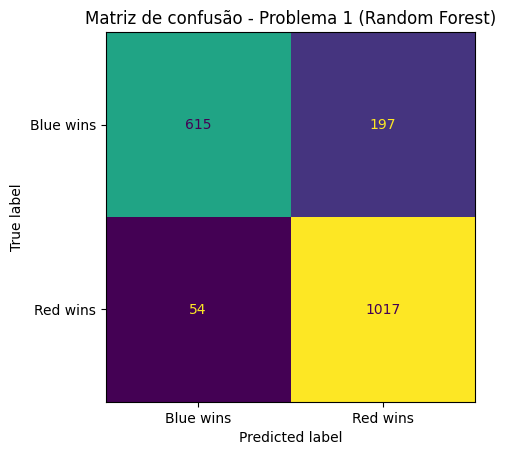

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# 1) Definindo modelo
rf_clf = Pipeline(steps=[
    ("prep", preprocess_A),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

# 2) Validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_auc_scores = cross_val_score(
    rf_clf,
    X_train_A,
    y_train_A,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

print("AUC-ROC (CV 5-fold) - Random Forest:", cv_auc_scores)
print("Média AUC-ROC (CV): {:.3f} ± {:.3f}".format(
    cv_auc_scores.mean(),
    cv_auc_scores.std()
))

# 3) Treinar no treino inteiro
rf_clf.fit(X_train_A, y_train_A)

# 4) Avaliar  teste
y_pred_rf = rf_clf.predict(X_test_A)
y_proba_rf = rf_clf.predict_proba(X_test_A)[:, 1]

print("\n--- Métricas Problema 1: Vencedor (Random Forest) ---")
print(classification_report(y_test_A, y_pred_rf, digits=3))

auc_rf = roc_auc_score(y_test_A, y_proba_rf)
print(f"AUC-ROC (Random Forest): {auc_rf:.3f}")

# Matriz de confusão
cm_rf = confusion_matrix(y_test_A, y_pred_rf)

plt.figure(figsize=(4,4))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Blue wins","Red wins"])
disp_rf.plot(colorbar=False)
plt.title("Matriz de confusão - Problema 1 (Random Forest)")
plt.show()


## 7. Problema 2 – Previsão do método de vitória (multiclasse)

Agora o objetivo é prever **como a luta termina**: por decisão, nocaute/KO, finalização ou outro método (`Other`).

Primeiro, analisamos a distribuição das classes no conjunto de treino.


In [27]:
train_df['method_simplified'].value_counts(dropna=False)


method_simplified
Decision      2928
KO/TKO        2128
Submission    1279
Other           91
Name: count, dtype: int64

In [13]:
(train_df['method_simplified'].value_counts(normalize=True) * 100).round(2)


method_simplified
Decision      45.56
KO/TKO        33.12
Submission    19.90
Other          1.42
Name: proportion, dtype: float64

### 7.1 Seleção de features

Para este problema removemos:

- IDs e nomes;
- colunas relacionadas ao vencedor (`winner`, `winner_bin`, `winner_id`);
- o próprio método de vitória (`method` e `method_simplified`);
- colunas que revelam diretamente o fim da luta (`finish_round`, `match_time_sec`, `total_rounds`, `duration`).

As demais colunas, incluindo as diferenças entre os lutadores, são utilizadas como preditoras.


In [ ]:
# colunas que nunca queremos como features (ids, nomes, resultado, etc.)
base_exclude_B = [
    'event_id', 'event_name', 'date', 'location', 'fight_id',
    'r_name', 'r_id', 'b_name', 'b_id', 'referee',
    'winner', 'winner_id',          # resultado
    'winner_bin',                   # target do problema 1
    'method',                       # método original detalhado
    'method_simplified',            # target deste problema
    'finish_round',                 # round em que terminou
    'match_time_sec',               # tempo total
    'total_rounds',                 # duração total
    'duration',                     # cópia
]

feature_cols_B = [c for c in train_df.columns if c not in base_exclude_B]

print("Número de features para Problema 2:", len(feature_cols_B))
print("Algumas delas:", feature_cols_B[:25])

# separar treino/teste já filtrando linhas com método válido
trainB_df = train_df.dropna(subset=['method_simplified'])
testB_df  = test_df.dropna(subset=['method_simplified'])

X_train_B = trainB_df[feature_cols_B]
y_train_B = trainB_df['method_simplified']

X_test_B  = testB_df[feature_cols_B]
y_test_B  = testB_df['method_simplified']

print("\nShapes X_train_B, X_test_B:", X_train_B.shape, X_test_B.shape)

# detectar tipos
cat_cols_B = X_train_B.select_dtypes(include=['object', 'bool']).columns.tolist()
num_cols_B = X_train_B.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nCategóricas detectadas (B):", cat_cols_B)
print("Nº de features numéricas (B):", len(num_cols_B))


Número de features para Problema 2: 120
Algumas delas: ['division', 'title_fight', 'r_kd', 'r_sig_str_landed', 'r_sig_str_atmpted', 'r_sig_str_acc', 'r_total_str_landed', 'r_total_str_atmpted', 'r_total_str_acc', 'r_td_landed', 'r_td_atmpted', 'r_td_acc', 'r_sub_att', 'r_ctrl', 'r_head_landed', 'r_head_atmpted', 'r_head_acc', 'r_body_landed', 'r_body_atmpted', 'r_body_acc', 'r_leg_landed', 'r_leg_atmpted', 'r_leg_acc', 'r_dist_landed', 'r_dist_atmpted']

Shapes X_train_B, X_test_B: (6426, 120) (1911, 120)

Categóricas detectadas (B): ['division', 'r_nick_name', 'r_stance', 'r_dob', 'b_nick_name', 'b_stance', 'b_dob']
Nº de features numéricas (B): 113


### 7.2 Modelo 1 – Regressão Logística multinomial

Aplicando o mesmo pipeline de pré-processamento (imputação + padronização + *one-hot*) e treinamos uma **Regressão Logística multinomial** para prever `method_simplified`.

As principais métricas utilizadas foram:

- **accuracy**;
- **F1-score macro**, para dar o mesmo peso a todas as classes (Decision, KO/TKO, Submission, Other).


C:\Users\igorr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



--- Métricas Problema 2: Método de vitória (Logistic Regression) ---
              precision    recall  f1-score   support

    Decision      0.908     0.889     0.899       958
      KO/TKO      0.794     0.836     0.815       591
       Other      0.087     0.091     0.089        22
  Submission      0.735     0.709     0.722       340

    accuracy                          0.832      1911
   macro avg      0.631     0.631     0.631      1911
weighted avg      0.833     0.832     0.832      1911

F1-score (macro): 0.631


<Figure size 600x600 with 0 Axes>

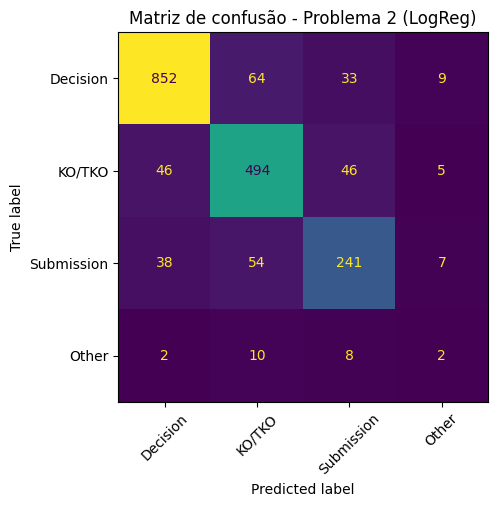

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

# 1) Transformers numéricos e categóricos
numeric_transformer_B = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_B = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_B = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_B, num_cols_B),
        ("cat", categorical_transformer_B, cat_cols_B),
    ]
)

# 2) Pipeline final com Regressão Logística multinomial
logreg_B = Pipeline(steps=[
    ("prep", preprocess_B),
    ("model", LogisticRegression(
        max_iter=1000,
        multi_class="multinomial",
        class_weight="balanced"  
    ))
])

# 3) Treinar
logreg_B.fit(X_train_B, y_train_B)

# 4) Avaliar
y_pred_B = logreg_B.predict(X_test_B)

print("\n--- Métricas Problema 2: Método de vitória (Logistic Regression) ---")
print(classification_report(y_test_B, y_pred_B, digits=3))

# F1 macro para resumir melhor (já que é multiclasse)
f1_macro_B = f1_score(y_test_B, y_pred_B, average="macro")
print(f"F1-score (macro): {f1_macro_B:.3f}")

# 5) Matriz de confusão
cm_B = confusion_matrix(y_test_B, y_pred_B, labels=["Decision","KO/TKO","Submission","Other"])

plt.figure(figsize=(6,6))
disp_B = ConfusionMatrixDisplay(confusion_matrix=cm_B,
                                display_labels=["Decision","KO/TKO","Submission","Other"])
disp_B.plot(colorbar=False)
plt.title("Matriz de confusão - Problema 2 (LogReg)")
plt.xticks(rotation=45)
plt.show()


### 7.3 Modelo 2 – Random Forest

Como segundo modelo, utilizamos um **Random Forest Classifier** com `class_weight="balanced"` para lidar com o desbalanceamento entre as classes de método de vitória.

Avaliando o modelo com validação cruzada (F1 macro) e comparamos o desempenho no conjunto de teste com a Regressão Logística multinomial.


F1 macro (CV 5-fold) - Random Forest (B): [0.57648013 0.57056674 0.57686124 0.57347122 0.57906239]
Média F1 macro (CV): 0.575 ± 0.003

--- Métricas Problema 2: Método de vitória (Random Forest) ---
              precision    recall  f1-score   support

    Decision      0.759     0.976     0.854       958
      KO/TKO      0.819     0.657     0.729       591
       Other      0.000     0.000     0.000        22
  Submission      0.878     0.529     0.661       340

    accuracy                          0.786      1911
   macro avg      0.614     0.540     0.561      1911
weighted avg      0.790     0.786     0.771      1911

F1-score (macro) - Random Forest: 0.561


C:\Users\igorr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\igorr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\igorr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_clas

<Figure size 600x600 with 0 Axes>

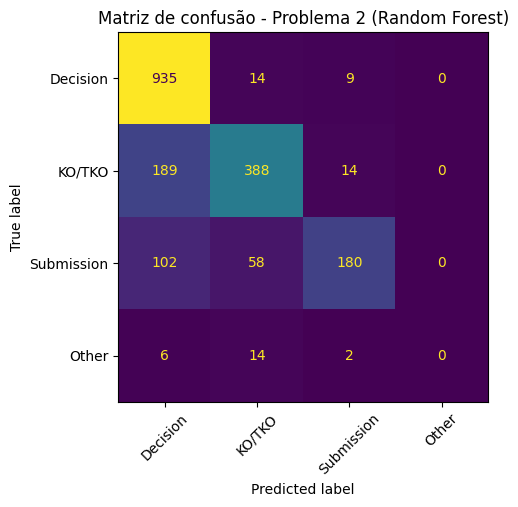

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1) Definir o modelo
rf_B = Pipeline(steps=[
    ("prep", preprocess_B),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"   # ajuda com as classes menos frequentes
    ))
])

# 2) Validação cruzada com F1 macro
cv_B = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_f1_macro = cross_val_score(
    rf_B,
    X_train_B,
    y_train_B,
    cv=cv_B,
    scoring="f1_macro",
    n_jobs=-1
)

print("F1 macro (CV 5-fold) - Random Forest (B):", cv_f1_macro)
print("Média F1 macro (CV): {:.3f} ± {:.3f}".format(
    cv_f1_macro.mean(),
    cv_f1_macro.std()
))

# 3) Treinar no treino inteiro
rf_B.fit(X_train_B, y_train_B)

# 4) Avaliar no teste
y_pred_rf_B = rf_B.predict(X_test_B)

print("\n--- Métricas Problema 2: Método de vitória (Random Forest) ---")
print(classification_report(y_test_B, y_pred_rf_B, digits=3))

f1_macro_rf_B = f1_score(y_test_B, y_pred_rf_B, average="macro")
print(f"F1-score (macro) - Random Forest: {f1_macro_rf_B:.3f}")

# 5) Matriz de confusão
cm_rf_B = confusion_matrix(y_test_B, y_pred_rf_B,
                           labels=["Decision","KO/TKO","Submission","Other"])

plt.figure(figsize=(6,6))
disp_rf_B = ConfusionMatrixDisplay(confusion_matrix=cm_rf_B,
                                   display_labels=["Decision","KO/TKO","Submission","Other"])
disp_rf_B.plot(colorbar=False)
plt.title("Matriz de confusão - Problema 2 (Random Forest)")
plt.xticks(rotation=45)
plt.show()


### 7.4 Resumo do Problema 2

- A **Regressão Logística multinomial** obteve accuracy em torno de **83%** e F1 macro ≈ **0,63**, com excelente desempenho para `Decision` e `KO/TKO` e desempenho razoável para `Submission`.
- O **Random Forest** apresentou accuracy menor (≈ 79%) e F1 macro ≈ **0,56**, com viés forte para a classe `Decision`.

Assim, a Regressão Logística multinomial foi escolhida como **modelo final** para o Problema 2.


## 8. Problema 3 – Previsão da duração da luta (regressão)

Neste problema queremos estimar **por quanto tempo a luta irá durar**, em segundos.

Definindo o alvo como `duration_sec`, baseado na coluna `match_time_sec`, e removendo das features todas as colunas relacionadas ao resultado final (quem venceu, método de vitória, round de término, etc.).


In [ ]:
# 1) Target: duração real em segundos
df['duration_sec'] = df['match_time_sec']

# 2) Remover lutas sem duração registrada
dfC = df.dropna(subset=['duration_sec']).copy()

# 3) Reaplicar o split temporal
trainC_df = dfC[dfC['date'] < "2022-01-01"].copy()
testC_df  = dfC[dfC['date'] >= "2022-01-01"].copy()

print("TrainC:", trainC_df.shape)
print("TestC :", testC_df.shape)

# 4) Colunas que NÃO podem ser usadas como features (ids, resultado, info do pós-luta)
base_exclude_C = [
    'event_id', 'event_name', 'date', 'location', 'fight_id',
    'r_name', 'r_id', 'b_name', 'b_id', 'referee',

    # resultados de quem ganhou e como ganhou
    'winner', 'winner_id', 'winner_bin',
    'method', 'method_simplified',

    # info diretamente ligada ao tempo final
    'finish_round',
    'match_time_sec',
    'total_rounds',
    'duration',        # antiga
    'duration_sec',    # target de regressão
]

feature_cols_C = [c for c in trainC_df.columns if c not in base_exclude_C]

print("\nNúmero de features para Problema 3:", len(feature_cols_C))
print("Algumas delas:", feature_cols_C[:25])

# 5) Montar X e y
X_train_C = trainC_df[feature_cols_C]
y_train_C = trainC_df['duration_sec']

X_test_C  = testC_df[feature_cols_C]
y_test_C  = testC_df['duration_sec']

print("\nShapes X_train_C, X_test_C:", X_train_C.shape, X_test_C.shape)

# 6) Detectar tipos
cat_cols_C = X_train_C.select_dtypes(include=['object', 'bool']).columns.tolist()
num_cols_C = X_train_C.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nCategóricas detectadas (C):", cat_cols_C)
print("Nº de features numéricas (C):", len(num_cols_C))


TrainC: (6426, 140)
TestC : (1911, 140)

Número de features para Problema 3: 120
Algumas delas: ['division', 'title_fight', 'r_kd', 'r_sig_str_landed', 'r_sig_str_atmpted', 'r_sig_str_acc', 'r_total_str_landed', 'r_total_str_atmpted', 'r_total_str_acc', 'r_td_landed', 'r_td_atmpted', 'r_td_acc', 'r_sub_att', 'r_ctrl', 'r_head_landed', 'r_head_atmpted', 'r_head_acc', 'r_body_landed', 'r_body_atmpted', 'r_body_acc', 'r_leg_landed', 'r_leg_atmpted', 'r_leg_acc', 'r_dist_landed', 'r_dist_atmpted']

Shapes X_train_C, X_test_C: (6426, 120) (1911, 120)

Categóricas detectadas (C): ['division', 'r_nick_name', 'r_stance', 'r_dob', 'b_nick_name', 'b_stance', 'b_dob']
Nº de features numéricas (C): 113


### 8.1 Modelo 1 – Regressão Linear

Como baseline, treino uma **Regressão Linear** com o mesmo pipeline de pré-processamento para prever `duration_sec`.

Avalio
 o modelo pelas métricas:

- **RMSE** (erro quadrático médio em segundos),
- **MAE** (erro absoluto médio em segundos),
- **R²** (proporção da variância explicada).


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1) Transformers numéricos e categóricos
numeric_transformer_C = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_C = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_C = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_C, num_cols_C),
        ("cat", categorical_transformer_C, cat_cols_C),
    ]
)

# 2) Pipeline final de regressão
linreg_C = Pipeline(steps=[
    ("prep", preprocess_C),
    ("model", LinearRegression())
])

# 3) Treinar
linreg_C.fit(X_train_C, y_train_C)

# 4) Prever no teste
y_pred_C = linreg_C.predict(X_test_C)

# 5) Métricas de regressão
mse = mean_squared_error(y_test_C, y_pred_C)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_C, y_pred_C)
r2 = r2_score(y_test_C, y_pred_C)

print("--- Métricas Problema 3: Duração (Linear Regression) ---")
print(f"RMSE: {rmse:.2f} segundos")
print(f"MAE : {mae:.2f} segundos")
print(f"R²  : {r2:.3f}")


print("\nEstatísticas da duração real (y_test_C):")
print(f"  média: {y_test_C.mean():.2f} s")
print(f"  desvio padrão: {y_test_C.std():.2f} s")
print(f"  mínimo: {y_test_C.min():.2f} s")
print(f"  máximo: {y_test_C.max():.2f} s")


--- Métricas Problema 3: Duração (Linear Regression) ---
RMSE: 132.96 segundos
MAE : 98.76 segundos
R²  : -1.212

Estatísticas da duração real (y_test_C):
  média: 232.63 s
  desvio padrão: 89.42 s
  mínimo: 8.00 s
  máximo: 300.00 s


### 8.2 Modelo 2 – Random Forest Regressor

Em seguida, testo um **Random Forest Regressor** para capturar relações não lineares entre as features e a duração da luta.

Utilizo validação cruzada (5-fold) com RMSE e avalio o modelo no conjunto de teste, comparando com a Regressão Linear.


RMSE (CV 5-fold) - Random Forest Regressor: [71.00718597 70.75528356 67.1377406  73.28250458 68.69195892]
Média RMSE (CV): 70.17 ± 2.10 segundos

--- Métricas Problema 3: Duração (Random Forest) ---
RMSE: 60.79 segundos
MAE : 38.81 segundos
R²  : 0.538


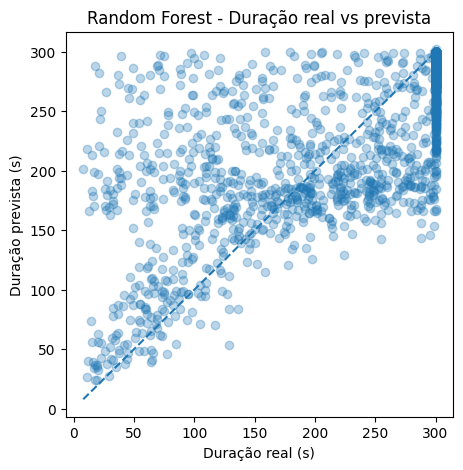

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score

# 1) Definir o modelo
rf_reg_C = Pipeline(steps=[
    ("prep", preprocess_C),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

# 2) Validação cruzada (5-fold) com RMSE
cv_C = KFold(n_splits=5, shuffle=True, random_state=42)

cv_rmse_scores = cross_val_score(
    rf_reg_C,
    X_train_C,
    y_train_C,
    cv=cv_C,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

print("RMSE (CV 5-fold) - Random Forest Regressor:", -cv_rmse_scores)
print("Média RMSE (CV): {:.2f} ± {:.2f} segundos".format(
    -cv_rmse_scores.mean(),
    cv_rmse_scores.std()
))

# 3) Treinar no treino inteiro
rf_reg_C.fit(X_train_C, y_train_C)

# 4) Avaliar no teste
y_pred_rf_C = rf_reg_C.predict(X_test_C)

mse_rf = mean_squared_error(y_test_C, y_pred_rf_C)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test_C, y_pred_rf_C)
r2_rf = r2_score(y_test_C, y_pred_rf_C)

print("\n--- Métricas Problema 3: Duração (Random Forest) ---")
print(f"RMSE: {rmse_rf:.2f} segundos")
print(f"MAE : {mae_rf:.2f} segundos")
print(f"R²  : {r2_rf:.3f}")

# 5) Gráfico simples: real vs previsto
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(y_test_C, y_pred_rf_C, alpha=0.3)
plt.xlabel("Duração real (s)")
plt.ylabel("Duração prevista (s)")
plt.title("Random Forest - Duração real vs prevista")
plt.plot([y_test_C.min(), y_test_C.max()],
         [y_test_C.min(), y_test_C.max()],
         linestyle="--")
plt.show()


### 8.3 Resumo do Problema 3

- A **Regressão Linear** apresentou desempenho fraco, com RMSE acima de 130 segundos, MAE próximo de 100 segundos e R² negativo (pior do que prever sempre a média).
- O **Random Forest Regressor** reduziu o erro médio para cerca de **39 segundos** (MAE), com RMSE em torno de **61 segundos** e R² ≈ **0,54**, explicando mais de metade da variância da duração.

Por isso, o Random Forest Regressor foi escolhido como **modelo final** para o Problema 3.


## 9. Conclusão

Neste projeto aplico técnicas de Machine Learning ao dataset **UFC Datasets 1994–2025** para resolver três problemas:

1. **Previsão do vencedor** (classificação binária):  
   - Melhor modelo: **Regressão Logística**, com accuracy ≈ 88% e AUC ≈ 0,95.

2. **Previsão do método de vitória** (multiclasse):  
   - Melhor modelo: **Regressão Logística multinomial**, com accuracy ≈ 83% e bom equilíbrio entre as principais classes (`Decision`, `KO/TKO`, `Submission`).

3. **Previsão da duração da luta** (regressão):  
   - Melhor modelo: **Random Forest Regressor**, com MAE ≈ 39 s e R² ≈ 0,54, superando em muito a Regressão Linear baseline.

O trabalho mostra como a combinação de:
- engenharia de atributos baseada em diferenças entre lutadores,
- split temporal para evitar *leakage*,
- pipelines de pré-processamento,
- e comparação entre modelos

permite construir soluções de Machine Learning robustas para um problema real do mundo esportivo.
